# Temporal Difference

In MC the agent has to wait until the end of an episode before it can update the estimate. Instead, we can wait for a single step and use the current value function estimate to estimate the return at the next step.

The hyperparameter alpha.

In [1]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

We write the prediction function that works for Temporal-Difference:

In [2]:
def td(pi, env, gamma=1.0, 
       init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
       n_episodes=500):
    
    nS = env.observation_space.n
    
    # initialize the variables needed
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # calculate the learning rate schedule for all episodes
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # loop for n_episodes
    for e in range(n_episodes):
        
        # get the initial state and then enter the interaction loop
        state, done = env.reset(), False
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # use the action to interact with the environment... 
            # roll out the policy one step
            next_state, reward, done, _ = env.step(action)
            
            # update V(s)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            
            # update the state variable for the next iteration
            state = next_state
            
        V_track[e] = V
        
    return V, V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [3]:
class Space:
    def __init__(self, value):
        self.n = value 
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(7)
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        self._state += np.random.choice([-1, 1])
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [4]:
env = RandomWalk()

We evaluate an "all-left" policy

In [5]:
def pi(state):
    return 1

We use the Temporal-Difference prediction algorithm and show the estimates over episodes

In [6]:
V_td, V_td_track = td(pi, env, n_episodes=500)

In [7]:
print(V_td)

[0.         0.16126158 0.34200412 0.5089349  0.66339524 0.85024619
 0.        ]


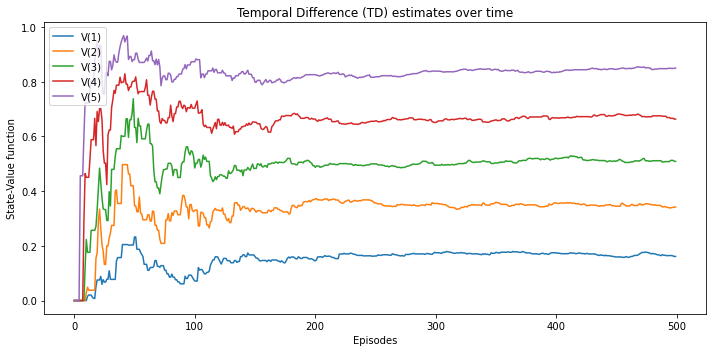

In [10]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.figure(figsize=(10,5))
plt.plot(V_td_track[:,1:6])
plt.title('Temporal Difference (TD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()